In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [44]:
#Define the number of elements in each set I, J, K
i_num = 27
k_num = 5
j_num = 500 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])


In [45]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 25000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 25000), 0)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 25000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 25000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 25000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 25000), 0)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,12096.0,2831.0
j1,j1,19589.0,9136.0
j2,j2,17233.0,15056.0
j3,j3,15898.0,14492.0
j4,j4,9836.0,2669.0
...,...,...,...
i22,i22,6721.0,12135.0
i23,i23,22449.0,13115.0
i24,i24,9170.0,16481.0


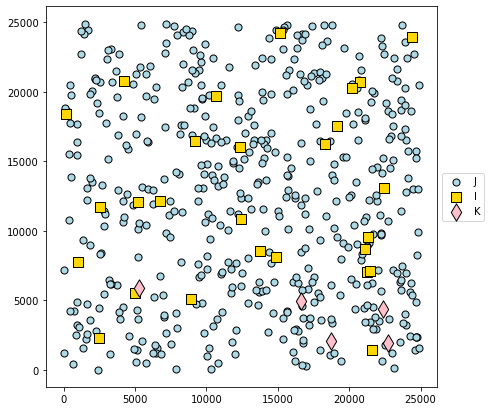

In [46]:
axs, fig = plt.subplots(1, 1, figsize = (7, 7))

fig.scatter(J['Latitude'], J['Longitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Latitude'], K['Longitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [47]:
# from pathlib import Path
# import pandas as pd
# import geopandas as gpd
# import shapely
# #%pip install folium matplotlib mapclassify
# import folium
# import matplotlib

# # Doctor's coordinates
# doctors = {'Latitude' : [48.56500199216254, 48.5705, 48.575], 'Longitude' : [13.433214775837387, 13.436, 13.44]}
# df = pd.DataFrame(doctors)
# df

# # create geodataframe, NB CRS
# geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4386")


# with open('Polygon Passau.txt', 'r') as file:
#     # Read the contents of the file into a string
#     polygon_str = file.read()

# # Now file_contents contains the contents of the file as a string
# passau_poly = shapely.wkt.loads(polygon_str)


# passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
# passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
# folium.GeoJson(passau_gdf).add_to(passau_map)

# geo_doctors = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4326")

# for idx, row in geo_doctors.iterrows():
#     folium.Marker([row['Latitude'], row['Longitude']], icon=folium.Icon(icon='circle', prefix='fa', color='blue'), 
#                   icon_size=(0.5, 0.5)).add_to(passau_map)

# lines = []
# for i in range(len(geo_doctors) - 1):
#     point1 = geo_doctors.iloc[i].geometry
#     point2 = geo_doctors.iloc[i + 1].geometry
#     lines.append([point1.coords[0], point2.coords[0]])

# folium.PolyLine(lines, color='blue').add_to(passau_map)



# passau_map

In [48]:
#Define constants

B = 17 * (90 * 60) #battery load: seconds of travel
S = 17 * (10 * 60) #meters of service time
alpha = 14760 + 500 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400000
    else:
        beta[j] = 300000
        
gamma = 0.0045 / 1000 # variable cost in euro per m
        
q_j = {j: 50 for j in J.index}

up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

mu

{'i0': 9,
 'i1': 11,
 'i2': 5,
 'i3': 9,
 'i4': 9,
 'i5': 8,
 'i6': 4,
 'i7': 5,
 'i8': 9,
 'i9': 4,
 'i10': 3,
 'i11': 6,
 'i12': 7,
 'i13': 4,
 'i14': 6,
 'i15': 10,
 'i16': 9,
 'i17': 4,
 'i18': 2,
 'i19': 2,
 'i20': 7,
 'i21': 3,
 'i22': 7,
 'i23': 5,
 'i24': 8,
 'i25': 11,
 'i26': 9}

Deterministic model

In [49]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 8,
 'i1': 12,
 'i2': 5,
 'i3': 10,
 'i4': 8,
 'i5': 7,
 'i6': 4,
 'i7': 7,
 'i8': 6,
 'i9': 4,
 'i10': 3,
 'i11': 7,
 'i12': 3,
 'i13': 4,
 'i14': 9,
 'i15': 8,
 'i16': 8,
 'i17': 5,
 'i18': 1,
 'i19': 2,
 'i20': 10,
 'i21': 6,
 'i22': 6,
 'i23': 6,
 'i24': 10,
 'i25': 8,
 'i26': 10}

In [50]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 10657.814644663324,
 ('k0', 'j1'): 7830.346416347108,
 ('k0', 'j2'): 14200.099612326669,
 ('k0', 'j3'): 14269.322198338645,
 ('k0', 'j4'): 12901.606295341677,
 ('k0', 'j5'): 17423.671254933615,
 ('k0', 'j6'): 23930.75314318377,
 ('k0', 'j7'): 8716.006941254693,
 ('k0', 'j8'): 11546.5823948041,
 ('k0', 'j9'): 7988.780758038112,
 ('k0', 'j10'): 21838.193171597326,
 ('k0', 'j11'): 23397.93796470108,
 ('k0', 'j12'): 23014.09014060734,
 ('k0', 'j13'): 30801.11484995308,
 ('k0', 'j14'): 829.6872904896157,
 ('k0', 'j15'): 20492.97684573913,
 ('k0', 'j16'): 7759.0732694053095,
 ('k0', 'j17'): 6222.530032068949,
 ('k0', 'j18'): 14579.032066635975,
 ('k0', 'j19'): 9080.292946816198,
 ('k0', 'j20'): 11381.46269158758,
 ('k0', 'j21'): 15014.586274686359,
 ('k0', 'j22'): 14504.683726300274,
 ('k0', 'j23'): 16128.458853839693,
 ('k0', 'j24'): 18676.090061894647,
 ('k0', 'j25'): 17239.307700716985,
 ('k0', 'j26'): 7659.4279812529085,
 ('k0', 'j27'): 24040.17990781267,
 ('k0', 'j28'): 3

In [51]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [52]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
KJ_feas


[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [53]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())
N_i

{'i0': [('k0', 'j1'),
  ('k0', 'j2'),
  ('k0', 'j3'),
  ('k0', 'j7'),
  ('k0', 'j8'),
  ('k0', 'j9'),
  ('k0', 'j14'),
  ('k0', 'j16'),
  ('k0', 'j17'),
  ('k0', 'j18'),
  ('k0', 'j19'),
  ('k0', 'j20'),
  ('k0', 'j22'),
  ('k0', 'j23'),
  ('k0', 'j26'),
  ('k0', 'j28'),
  ('k0', 'j33'),
  ('k0', 'j34'),
  ('k0', 'j36'),
  ('k0', 'j39'),
  ('k0', 'j48'),
  ('k0', 'j52'),
  ('k0', 'j55'),
  ('k0', 'j58'),
  ('k0', 'j60'),
  ('k0', 'j63'),
  ('k0', 'j64'),
  ('k0', 'j65'),
  ('k0', 'j66'),
  ('k0', 'j67'),
  ('k0', 'j75'),
  ('k0', 'j79'),
  ('k0', 'j81'),
  ('k0', 'j82'),
  ('k0', 'j83'),
  ('k0', 'j84'),
  ('k0', 'j85'),
  ('k0', 'j86'),
  ('k0', 'j87'),
  ('k0', 'j88'),
  ('k0', 'j89'),
  ('k0', 'j94'),
  ('k0', 'j97'),
  ('k0', 'j99'),
  ('k0', 'j100'),
  ('k0', 'j104'),
  ('k0', 'j112'),
  ('k0', 'j117'),
  ('k0', 'j118'),
  ('k0', 'j124'),
  ('k0', 'j125'),
  ('k0', 'j127'),
  ('k0', 'j131'),
  ('k0', 'j135'),
  ('k0', 'j138'),
  ('k0', 'j139'),
  ('k0', 'j142'),
  ('k0', 'j145'),


In [69]:
model_det = gp.Model('Deterministic model without relaxation')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [70]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj_final[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in L for i in M_kj_final[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in L for i in M_kj_final[(k, j)]), name = 'c6')

{('k0', 'j0', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i11'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i18'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i19'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i20'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i26'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i0'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i4'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i11'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i16'): <gurobi.Constr *Awaiting Model Update*>,

In [71]:
model_det.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] * 24 for (k, j) in L for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 55277 rows, 72352 columns and 107705 nonzeros
Model fingerprint: 0x508c1cc5
Variable types: 0 continuous, 72352 integer (532 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
Found heuristic solution: objective 1.300164e+07
Presolve removed 52590 rows and 45525 columns
Presolve time: 0.15s
Presolved: 2687 rows, 26827 columns, 55250 nonzeros
Variable types: 0 continuous, 26827 integer (1552 binary)
Found heuristic solution: objective 1.260163e+07

Root relaxation: objective 2.913916e+06, 18336 iterations, 0.60 seconds (0.75 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl

In [72]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 7
0
3.60141e+06 
x_ikj[i0,k1,k1] 8
x_ikj[i1,k1,k1] 12
x_ikj[i2,k3,i17] 5
x_ikj[i3,k1,i5] 10
x_ikj[i4,k1,k1] 8
x_ikj[i5,k1,i5] 7
x_ikj[i6,k3,i17] 4
x_ikj[i7,k1,i5] 7
x_ikj[i8,k3,i17] 6
x_ikj[i9,k3,i17] 4
x_ikj[i10,k1,i5] 3
x_ikj[i11,k1,k1] 7
x_ikj[i12,k1,i5] 3
x_ikj[i13,k4,i5] 4
x_ikj[i14,k1,i5] 9
x_ikj[i15,k1,k1] 8
x_ikj[i16,k1,i5] 8
x_ikj[i17,k3,i17] 5
x_ikj[i18,k1,k1] 1
x_ikj[i19,k3,i17] 2
x_ikj[i20,k4,k1] 10
x_ikj[i21,k4,k1] 6
x_ikj[i22,k3,i17] 6
x_ikj[i23,k1,k1] 6
x_ikj[i24,k3,i17] 10
x_ikj[i25,k3,i17] 8
x_ikj[i26,k2,k1] 10
y_j[k1] 1
y_j[i5] 1
y_j[i17] 1


1
3.60141e+06 
x_ikj[i0,k1,k1] 8
x_ikj[i1,k1,k1] 12
x_ikj[i2,k3,i17] 5
x_ikj[i3,k1,i5] 10
x_ikj[i4,k1,k1] 8
x_ikj[i5,k1,i5] 7
x_ikj[i6,k3,i17] 4
x_ikj[i7,k1,i5] 7
x_ikj[i8,k3,i17] 6
x_ikj[i9,k3,i17] 4
x_ikj[i10,k1,i5] 3
x_ikj[i11,k1,k1] 7
x_ikj[i12,k1,i5] 3
x_ikj[i13,k4,i5] 4
x_ikj[i14,k1,i5] 9
x_ikj[i15,k1,k1] 8
x_ikj[i16,k1,i5] 8
x_ikj[i17,k3,i17] 5
x_ikj[i18,k1,k1] 1
x_ikj[i19,k3,i17] 2
x_ikj[i20,k4,

In [73]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations, results_labs

SolutionSummary(model_det)

(      i  Number of drones
 0    i0                 8
 1    i1                12
 2   i10                 3
 3   i11                 7
 4   i12                 3
 5   i13                 4
 6   i14                 9
 7   i15                 8
 8   i16                 8
 9   i17                 5
 10  i18                 1
 11  i19                 2
 12   i2                 5
 13  i20                10
 14  i21                 6
 15  i22                 6
 16  i23                 6
 17  i24                10
 18  i25                 8
 19  i26                10
 20   i3                10
 21   i4                 8
 22   i5                 7
 23   i6                 4
 24   i7                 7
 25   i8                 6
 26   i9                 4,
      j  Number of drones
 0  i17                50
 1   i5                51
 2   k1                76,
     k  Number of drones
 0  k1                97
 1  k2                10
 2  k3                50
 3  k4                20)

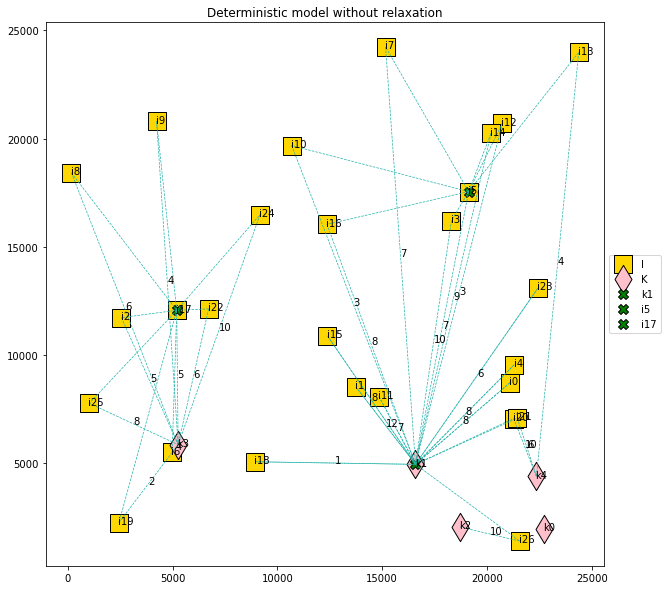

In [74]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (10, 10))
                
        fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Latitude'][i] - 40, I['Longitude'][i] - 60))
                
        fig.scatter(K['Latitude'], K['Longitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Latitude'][k] - 40, K['Longitude'][k] - 60))
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        (J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        (I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                (K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                                # fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                #                                 (J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

In [60]:
for v in model_det.getVars():
        if v.xn > 0:
            if v.varName.startswith('x_ikj'):
                indices_x = v.varName[6:-1].split(',')
indices_x

['i26', 'k2', 'k1']

Probabilistic model

In [61]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.98

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 15

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [62]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [63]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [64]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')

{('k0', 'j0', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i11'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i18'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i19'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i20'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i26'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i0'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i4'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i11'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j1', 'i16'): <gurobi.Constr *Awaiting Model Update*>,

In [65]:
model_prob.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gamma * gp.quicksum((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i[i] for i in I.index), GRB.MINIMIZE)
model_prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17391 rows, 74992 columns and 9674251 nonzeros
Model fingerprint: 0xe2571640
Variable types: 0 continuous, 74992 integer (3172 binary)
Coefficient statistics:
  Matrix range     [1e-13, 5e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 9e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.165986e+07
Presolve removed 12091 rows and 48164 columns (presolve time = 6s) ...
Presolve removed 14704 rows and 48164 columns
Presolve time: 6.51s
Presolved: 2687 rows, 26828 columns, 55277 nonzeros
Variable types: 0 continuous, 26828 integer (532 binary)
Found heuristic solution: objective 1.159882e+

In [66]:
ListSolution(model_prob)

Number of solutions found: 5
0
1.14418e+06 
x_ikj[i0,k2,i3] 16
x_ikj[i1,k4,i3] 18
x_ikj[i2,k1,i2] 10
x_ikj[i3,k0,i3] 3
x_ikj[i3,k1,i3] 13
x_ikj[i4,k0,i3] 8
x_ikj[i4,k4,i3] 8
x_ikj[i5,k4,i3] 14
x_ikj[i6,k2,i2] 9
x_ikj[i7,k4,i3] 10
x_ikj[i8,k0,i2] 11
x_ikj[i8,k2,i2] 5
x_ikj[i9,k1,i2] 9
x_ikj[i10,k0,i3] 7
x_ikj[i11,k3,i3] 12
x_ikj[i12,k2,i3] 13
x_ikj[i13,k1,i3] 9
x_ikj[i14,k0,i3] 12
x_ikj[i15,k2,i3] 17
x_ikj[i16,k1,i3] 5
x_ikj[i16,k3,i3] 11
x_ikj[i17,k0,i2] 9
x_ikj[i18,k3,i2] 5
x_ikj[i19,k2,i2] 5
x_ikj[i20,k1,i3] 13
x_ikj[i21,k0,i3] 7
x_ikj[i22,k2,i2] 13
x_ikj[i23,k1,i3] 10
x_ikj[i24,k0,i3] 13
x_ikj[i24,k2,i3] 1
x_ikj[i25,k0,i2] 18
x_ikj[i26,k2,k1] 16
y_j[k1] 1
y_j[i2] 1
y_j[i3] 1


1
1.54418e+06 
x_ikj[i0,k2,i3] 16
x_ikj[i1,k4,i3] 18
x_ikj[i2,k1,i2] 10
x_ikj[i3,k0,i3] 3
x_ikj[i3,k1,i3] 13
x_ikj[i4,k0,i3] 8
x_ikj[i4,k4,i3] 8
x_ikj[i5,k4,i3] 14
x_ikj[i6,k2,i2] 9
x_ikj[i7,k4,i3] 10
x_ikj[i8,k0,i2] 11
x_ikj[i8,k2,i2] 5
x_ikj[i9,k1,i2] 9
x_ikj[i10,k0,i3] 7
x_ikj[i11,k3,i3] 12
x_ikj[i12,k2,i3]

In [67]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                16
 1    i1                18
 2   i10                 7
 3   i11                12
 4   i12                13
 5   i13                 9
 6   i14                12
 7   i15                17
 8   i16                16
 9   i17                 9
 10  i18                 5
 11  i19                 5
 12   i2                10
 13  i20                13
 14  i21                 7
 15  i22                13
 16  i23                10
 17  i24                14
 18  i25                18
 19  i26                16
 20   i3                16
 21   i4                16
 22   i5                14
 23   i6                 9
 24   i7                10
 25   i8                16
 26   i9                 9,
     j  Number of drones
 0  i2                94
 1  i3               220
 2  k1                16,
     k  Number of drones
 0  k0                88
 1  k1                69
 2  k2                95
 3  k3                28
 4  k4           

KeyboardInterrupt: 

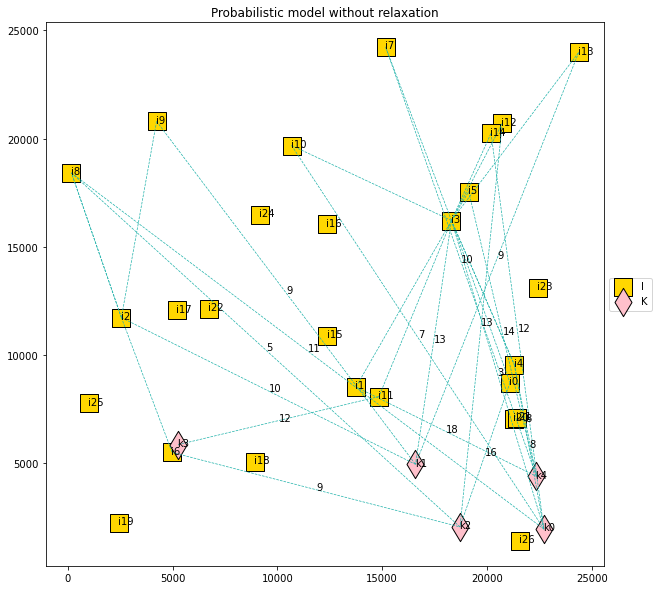

In [68]:
SolutionGraph(I, K, J, model_prob)

Probabilistic model with relaxed constraints

In [ ]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [ ]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [ ]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [ ]:
#Redefine constants and random variables


I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))

In [ ]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [ ]:
model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')



model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')


model_prob_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c20')




Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('k0', 'j0', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i18'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j0', 'i19'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j5', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j5', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j5', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j5', 'i11'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j5', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j5', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j5', 'i18'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j5', 'i19'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j7', 'i11'): <gurobi.Constr *Awaiting Model Update*>,

In [ ]:
model_prob_rel.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gamma * gp.quicksum((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i[i] for i in I.index), GRB.MINIMIZE)
model_prob_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11256 rows, 55395 columns and 7985881 nonzeros
Model fingerprint: 0x9f553a29
Variable types: 0 continuous, 55395 integer (2895 binary)
Coefficient statistics:
  Matrix range     [1e-13, 3e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 9e+04]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 8327315.2351
Presolve removed 8611 rows and 35549 columns
Presolve time: 4.74s
Presolved: 2645 rows, 19846 columns, 41285 nonzeros
Variable types: 0 continuous, 19846 integer (525 binary)
Found heuristic solution: objective 8312055.2351

Root simplex log...

Iteration    Objective       Primal Inf.    Dua

In [ ]:
ListSolution(model_prob_rel)

Number of solutions found: 3
0
1.11366e+06 
x_ikj[i0,k1,i5] 14
x_ikj[i1,k2,k2] 18
x_ikj[i2,k4,k2] 18
x_ikj[i3,k3,i5] 20
x_ikj[i4,k0,i5] 16
x_ikj[i5,k2,i5] 5
x_ikj[i6,k1,k2] 14
x_ikj[i7,k1,i5] 14
x_ikj[i8,k1,k2] 14
x_ikj[i9,k3,k2] 16
x_ikj[i10,k2,k2] 3
x_ikj[i11,k0,k2] 18
x_ikj[i12,k1,i5] 9
x_ikj[i13,k0,i5] 10
x_ikj[i14,k4,i5] 16
x_ikj[i15,k2,k2] 18
x_ikj[i16,k4,k2] 10
x_ikj[i17,k3,k2] 16
x_ikj[i18,k4,k2] 16
x_ikj[i19,k0,i17] 14
y_j[k2] 1
y_j[i5] 1
y_j[i17] 1


1
8.31206e+06 
x_ikj[i0,k1,i5] 14
x_ikj[i1,k2,k2] 18
x_ikj[i2,k4,k2] 18
x_ikj[i3,k3,i5] 20
x_ikj[i4,k0,i5] 16
x_ikj[i5,k2,i5] 5
x_ikj[i6,k1,k2] 14
x_ikj[i7,k1,i5] 14
x_ikj[i8,k1,k2] 14
x_ikj[i9,k3,k2] 16
x_ikj[i10,k2,k2] 3
x_ikj[i11,k0,k2] 18
x_ikj[i12,k1,i5] 9
x_ikj[i13,k0,i5] 10
x_ikj[i14,k4,i5] 16
x_ikj[i15,k2,k2] 18
x_ikj[i16,k4,k2] 10
x_ikj[i17,k3,k2] 16
x_ikj[i18,k4,k2] 16
x_ikj[i19,k0,i17] 14
y_j[k2] 1
y_j[i5] 1
y_j[i17] 1


2
8.32732e+06 
x_ikj[i0,k1,i5] 14
x_ikj[i1,k2,k2] 18
x_ikj[i2,k4,k2] 18
x_ikj[i3,k3,i5] 20
x_ikj[i4

In [ ]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                14
 1    i1                18
 2   i10                 3
 3   i11                18
 4   i12                 9
 5   i13                10
 6   i14                16
 7   i15                18
 8   i16                10
 9   i17                16
 10  i18                16
 11  i19                14
 12   i2                18
 13   i3                20
 14   i4                16
 15   i5                 5
 16   i6                14
 17   i7                14
 18   i8                14
 19   i9                16,
      j  Number of drones
 0  i17                14
 1   i5               104
 2   k2               161)

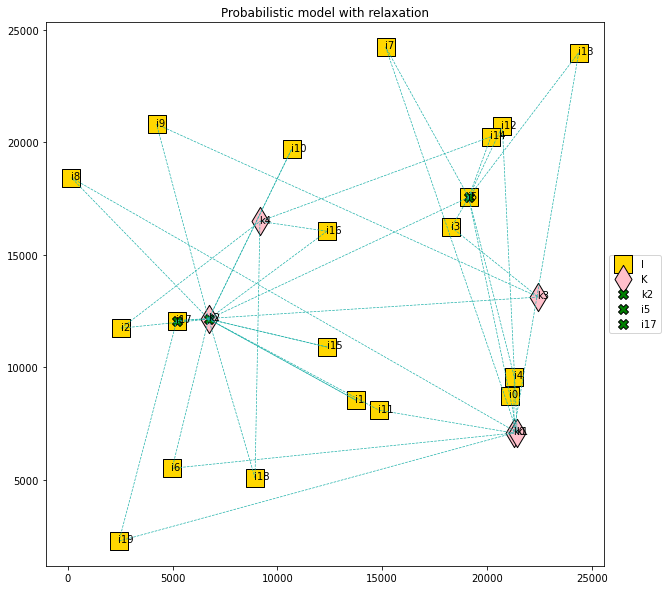

In [ ]:
SolutionGraph(I, K, J, model_prob_rel)

Deterministic model with relaxed constraints

In [ ]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [ ]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c21')
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c22')

model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')

model_det_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c25')

model_det_rel.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i] for i in I.index) + gp.quicksum(beta[j] * y_j[j] for j in J.index) + gamma * gp.quicksum((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] for (k, j) in N_i[i] for i in I.index), GRB.MINIMIZE)
model_det_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8905 rows, 53025 columns and 47500 nonzeros
Model fingerprint: 0xd6d52592
Variable types: 0 continuous, 53025 integer (525 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
Found heuristic solution: objective 8037358.4504
Presolve removed 6260 rows and 33180 columns
Presolve time: 0.06s
Presolved: 2645 rows, 19845 columns, 41265 nonzeros
Found heuristic solution: objective 1237358.4504
Variable types: 0 continuous, 19845 integer (545 binary)

Root relaxation: objective 3.353406e+05, 2962 iterations, 0.22 seconds (0.42 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  O

In [ ]:
ListSolution(model_det_rel)

Number of solutions found: 4
0
1.03736e+06 
x_ikj[i0,k4,i5] 12
x_ikj[i1,k0,k2] 20
x_ikj[i2,k0,k2] 5
x_ikj[i3,k0,i5] 50
x_ikj[i4,k1,i5] 5
x_ikj[i5,k1,i5] 2
x_ikj[i6,k0,k2] 3
x_ikj[i7,k1,i5] 40
x_ikj[i8,k0,k2] 10
x_ikj[i9,k0,k2] 12
x_ikj[i10,k3,k2] 1
x_ikj[i11,k3,k2] 26
x_ikj[i12,k1,i5] 3
x_ikj[i13,k4,i5] 38
x_ikj[i14,k2,i5] 50
x_ikj[i14,k3,i5] 50
x_ikj[i15,k3,k2] 7
x_ikj[i16,k3,k2] 5
x_ikj[i17,k3,k2] 11
x_ikj[i18,k1,k2] 50
x_ikj[i18,k2,k2] 50
x_ikj[i18,k4,k2] 50
x_ikj[i19,k4,i17] 9
y_j[k2] 1
y_j[i5] 1
y_j[i17] 1


1
1.03736e+06 
x_ikj[i0,k4,i5] 12
x_ikj[i1,k0,k2] 20
x_ikj[i2,k0,k2] 5
x_ikj[i3,k0,i5] 50
x_ikj[i4,k1,i5] 5
x_ikj[i5,k1,i5] 2
x_ikj[i6,k0,k2] 3
x_ikj[i7,k1,i5] 40
x_ikj[i8,k0,k2] 10
x_ikj[i9,k0,k2] 12
x_ikj[i10,k3,k2] 1
x_ikj[i11,k3,k2] 26
x_ikj[i12,k1,i5] 3
x_ikj[i13,k4,i5] 38
x_ikj[i14,k2,i5] 50
x_ikj[i14,k3,i5] 50
x_ikj[i15,k3,k2] 7
x_ikj[i16,k3,k2] 5
x_ikj[i17,k3,k2] 11
x_ikj[i18,k1,k2] 50
x_ikj[i18,k2,k2] 50
x_ikj[i18,k4,k2] 50
x_ikj[i19,k4,i17] 9
y_j[k2] 1
y_j[i5] 1
y_j[

In [ ]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                12
 1    i1                20
 2   i10                 1
 3   i11                26
 4   i12                 3
 5   i13                38
 6   i14               100
 7   i15                 7
 8   i16                 5
 9   i17                11
 10  i18               150
 11  i19                 9
 12   i2                 5
 13   i3                50
 14   i4                 5
 15   i5                 2
 16   i6                 3
 17   i7                40
 18   i8                10
 19   i9                12,
      j  Number of drones
 0  i17                 9
 1   i5               250
 2   k2               250)

KeyboardInterrupt: 

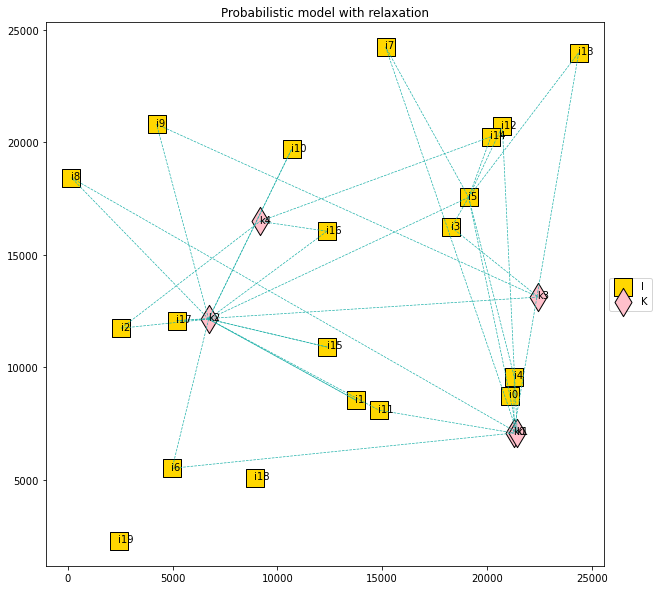

In [ ]:
SolutionGraph(I, K, J, model_prob_rel)

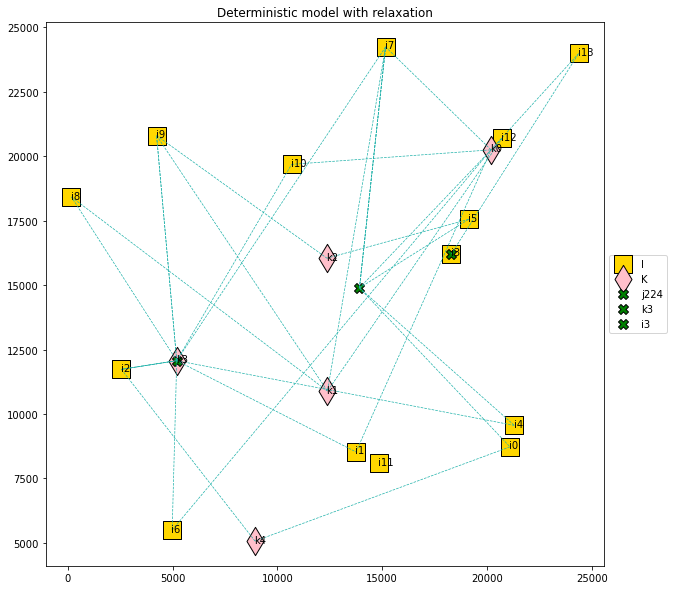

In [ ]:
SolutionGraph(I, K, J, model_det_rel)

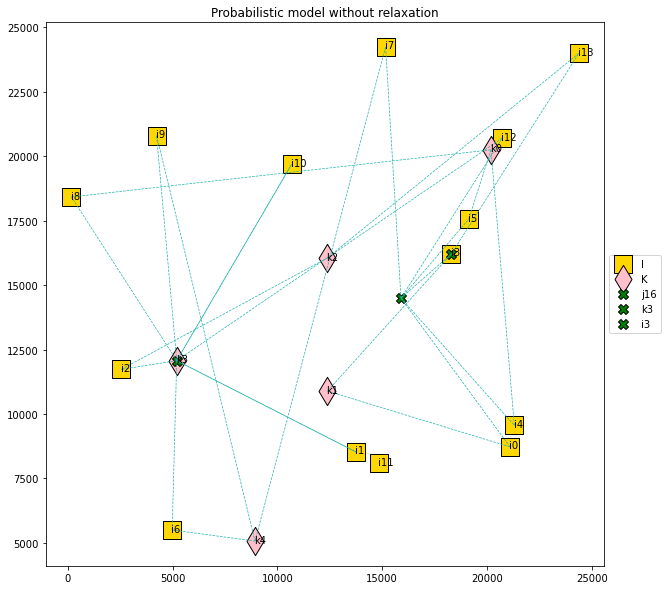

In [ ]:
SolutionGraph(I, K, J, model_prob)

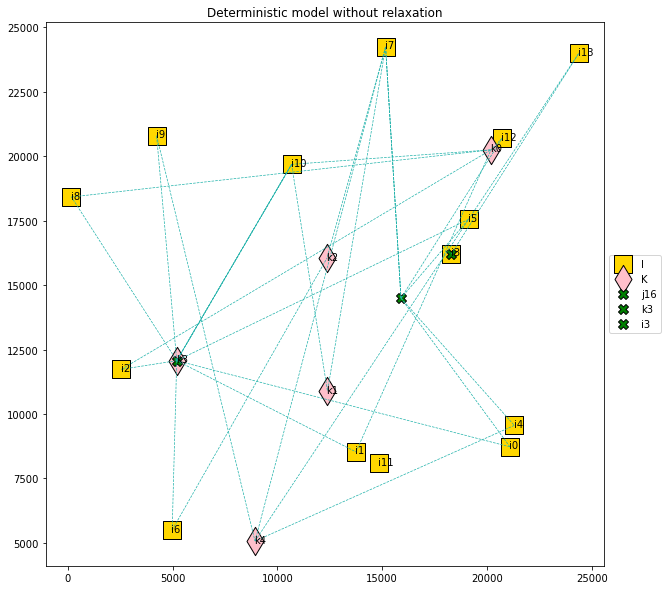

In [ ]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty